In [1]:
using Pkg; Pkg.activate("C:\\Users\\KarlH\\Desktop\\ComputationalPhysicsMaster\\OrbitalNeuralMethods")
using Revise
using OrbitalNeuralMethods
import OrbitalNeuralMethods as onm

  Activating project at `C:\Users\KarlH\Desktop\ComputationalPhysicsMaster\OrbitalNeuralMethods`


In [11]:
import Plots as plt
plt.pyplot()

Plots.PyPlotBackend()

In [7]:
n = 2
ω = 0.25
ham = HOCoulomb(ω, shielding = 0.25);

l = 10
basis = SpinBasis(HOBasis(l, ω))
grid = [x for x in range(-10, stop = 10, length = 2001)]
system = System(n, basis, grid, ham);

rhf = RHF(system);
rhf = compute_ground_state!(rhf, max_iter = 100, tol = 1e-10, verbose=0);
slater = Slater(rhf);

In [4]:
function energy_opt(wf, optimizer)
    ham = HOCoulomb(0.25, shielding = 0.25);

    metro = Importance(equils = 1e4, samples = 1e4, step = 0.01);
    t = @elapsed wf_final, wf_opt, grad_results = optimize(wf, ham, metro, optimizer, nthreads = 12, verbose = true);
    println("\nGradient time: $(t) s")
    return wf_final, wf_opt
end

function energy_block(wf)
    samples_b = 2^23
    metro_b = Importance(equils = 1e6, samples = samples_b, step = 0.01);
    t = @elapsed result = blocking(wf, ham, metro_b, nthreads = 12);
    digits = Integer(-floor(log10(result.E_err)))
    print("$(round(result.E, digits=digits)) ± $(round(result.E_err, digits=digits)), $(round(result.E - 0.8247, digits=digits))")
    println("\nBlocking time: $(t) s")
end

energy_block (generic function with 1 method)

In [8]:
nn = NeuralNetwork([Dense(32), Tanh, Dense(1), Exp], n);
wf = SlaterNN(slater, nn);
optimizer = ADAM(wf, lr = 0.01, max_iter = 500, tol = 1e-6);

wf32_final, wf32_opt = energy_opt(wf, optimizer);
energy_block(wf32_final);
energy_block(wf32_opt);

E = 0.831603 iter = 500/500                                      
Gradient time: 30.0781561 s
0.8364 ± 0.0002, 0.0117
Blocking time: 9.023085 s
0.826 ± 0.0009, 0.0013
Blocking time: 8.7105724 s


### Density

In [16]:
hf = HF(system)
hf = compute_ground_state!(hf, max_iter = 1000, tol = 1e-10, verbose=0);
hf_density = particle_density(System(hf));

In [10]:
rhf_density  = particle_density(System(rhf));

In [12]:
include("imgplot.jl");

In [13]:
metro = Importance(equils = 1e5, samples = 1e8, step = 0.01);
ob_result = onebody(wf32_final, ham, metro, start = -10, stop = 10, length = 200, nthreads = 12);
(; radius, oneBodyDensity) = ob_result;

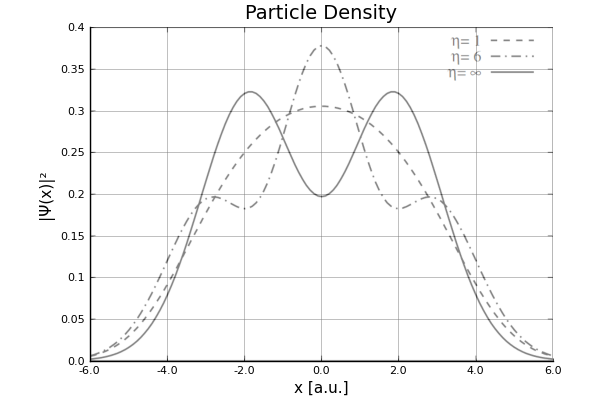

In [14]:
x_trans, y_trans = imgplot(file     = "Figures/GS.PNG",
                           extent   = [-6, 6, 0, 0.4],
                           imgalpha = 0.5,
                           yticks   = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
                           xticks   = [x for x in -6:2:6],
                           )
plt.plot!(legend=:topleft, title="Particle Density", xlabel="x [a.u.]", ylabel="|Ψ(x)|²")

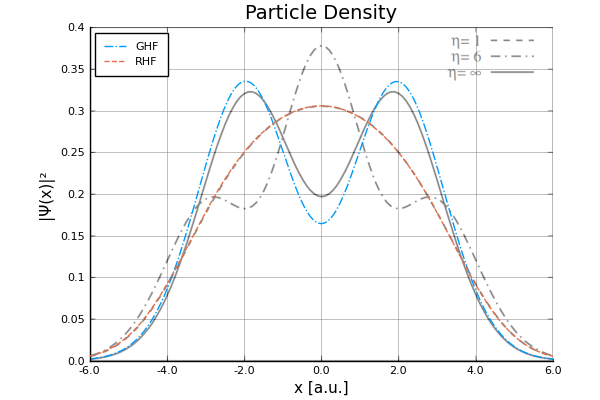

In [17]:
x_trans, y_trans = imgplot(file     = "Figures/GS.PNG",
                           extent   = [-6, 6, 0, 0.4],
                           imgalpha = 0.5,
                           yticks   = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
                           xticks   = [x for x in -6:2:6],
                           )

plt.plot!(legend=:topleft, title="Particle Density", xlabel="x [a.u.]", ylabel="|Ψ(x)|²")
plt.plot!(x_trans.(grid), y_trans.(hf_density), label="GHF", lw=1, c=1, ls=:dashdot)
plt.plot!(x_trans.(grid), y_trans.(rhf_density), label="RHF", lw=1, c=2, ls=:dash)
plt.plot!()

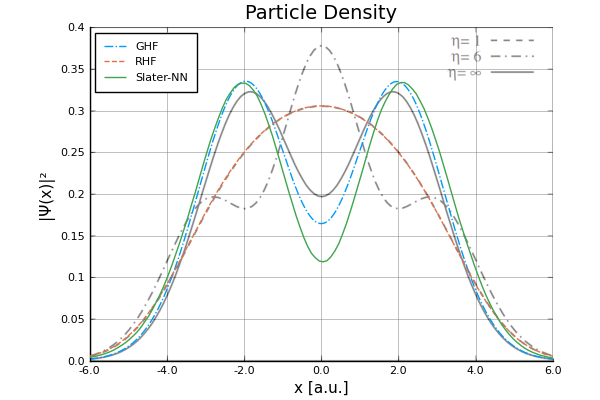

In [18]:
x_trans, y_trans = imgplot(file     = "Figures/GS.PNG",
                           extent   = [-6, 6, 0, 0.4],
                           imgalpha = 0.5,
                           yticks   = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
                           xticks   = [x for x in -6:2:6],
                           )

plt.plot!(legend=:topleft, title="Particle Density", xlabel="x [a.u.]", ylabel="|Ψ(x)|²")
plt.plot!(x_trans.(grid), y_trans.(hf_density), label="GHF", lw=1, c=1, ls=:dashdot)
plt.plot!(x_trans.(grid), y_trans.(rhf_density), label="RHF", lw=1, c=2, ls=:dash)
plt.plot!(x_trans.(radius), y_trans.(oneBodyDensity.*2), label="Slater-NN", lw=1, c=3)
plt.plot!()